<a href="https://colab.research.google.com/github/BootCamp-BMA/colabs/blob/main/distilBert83accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import data set

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords



# ===========================
# 1. MOUNT GOOGLE DRIVE & LOAD DATASET
# ===========================

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
file_path = "/content/drive/My Drive/News _dataset/FakeNewsNet.csv"
df = pd.read_csv(file_path)


print ('-------------------------------')
print(df.isnull().sum())
print ('-------------------------------')



print (df.shape)
print ('-------------------------------')
df.head()


Mounted at /content/drive
-------------------------------
title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64
-------------------------------
(23196, 5)
-------------------------------


,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


# ===========================
# 2. DATA VISUALIZATION
# ===========================

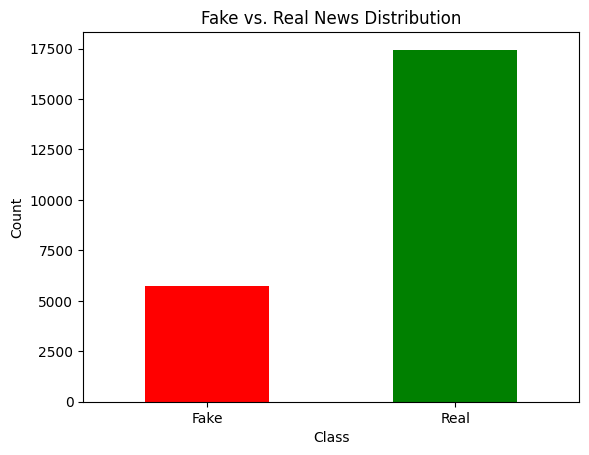

,proportion
real,
1,0.751897
0,0.248103


In [ ]:

df['real'].value_counts().sort_index().plot(kind='bar', color=['red', 'green'])
plt.xticks(ticks=[0, 1], labels=['Fake', 'Real'], rotation=0)
plt.title("Fake vs. Real News Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()
df['real'].value_counts(normalize=True)


# ===========================
# 3. DATA PREPROCESSING
# ===========================

In [ ]:

df = df[['title', 'real']].dropna().drop_duplicates()

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^a-zA-Z\s\']', '', text)
    # text = ' '.join(word for word in text.split() if word not in stop_words)
    return text
df['title'] = df['title'].apply(clean_text)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,real
0,kandi burruss explodes rape accusation 'real h...,1
1,people's choice awards best red carpet looks,1
2,sophia bush sends sweet birthday message 'one ...,1
3,colombian singer maluma sparks rumours inappro...,1
4,gossip girl years later upper east siders shoc...,1


# ===========================
# 4. TOKENIZATION
# ===========================

In [ ]:

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['title'].tolist(), df['real'].tolist(), test_size=0.2, random_state=42
)

train_tokens = tokenizer.batch_encode_plus(train_texts, max_length=64, padding='max_length', truncation=True, return_tensors='pt')
test_tokens = tokenizer.batch_encode_plus(test_texts, max_length=64, padding='max_length', truncation=True, return_tensors='pt')

train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

for i in range(3):  # Print top 3 examples
    input_ids = train_tokens['input_ids'][i]  # Get token IDs
    tokens = tokenizer.convert_ids_to_tokens(input_ids)  # Convert IDs to tokens

    print(f"Original Text: {train_texts[i]}")
    print(f"Tokenized: {tokens}")
    print(f"Token IDs: {input_ids.tolist()}")  # Convert tensor to list
    print(f"Label: {train_labels[i].item()}")
    print("-" * 50)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Original Text: liam payne niall horan partial one direction reunion indiana concert
Tokenized: ['[CLS]', 'liam', 'payne', 'niall', 'ho', '##ran', 'partial', 'one', 'direction', 'reunion', 'indiana', 'concert', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Token IDs: [101, 8230, 13470, 21889, 7570, 5521, 7704, 2028, 3257, 10301, 5242, 4164, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: 1
--------------------------------------------------
Original Text: bru

# ===========================
# 5. CREATE DATA LOADERS
# ===========================

In [ ]:
train_data = TensorDataset(train_tokens['input_ids'], train_tokens['attention_mask'], train_labels)
test_data = TensorDataset(test_tokens['input_ids'], test_tokens['attention_mask'], test_labels)

batch_size = 16
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# ===========================
# 6. MODEL INITIALIZATION
# ===========================

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

layer_control = {
    0: True,
    1: True,
    2: True,
    3: True,
    4: False,
    5: False
}

for i, layer in enumerate(model.distilbert.transformer.layer):
    for param in layer.parameters():
        param.requires_grad = layer_control[i]



# Print model architecture to show it has been loaded properly
print("----------------------------------------")
print(len(model.distilbert.transformer.layer))
print("----------------------------------------")
for i, layer in enumerate(model.distilbert.transformer.layer):
    trainable = any(param.requires_grad for param in layer.parameters())
    print(f"Layer {i}: {'Trainable' if trainable else 'Frozen'}")
print("----------------------------------------")
model



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------
6
----------------------------------------
Layer 0: Trainable
Layer 1: Trainable
Layer 2: Trainable
Layer 3: Trainable
Layer 4: Frozen
Layer 5: Frozen
----------------------------------------


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# ===========================
# 7. TRAINING SETUP
# ===========================

In [ ]:
import time
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
num_epochs = 5
num_training_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

class_weights = torch.tensor([2.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

def train(model, train_dataloader, optimizer, criterion, lr_scheduler, device, epochs=5):
    print("Starting Training...\n")
    model.train()
    start_time = time.time()  # Start timing
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        loop = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}")
        for batch in loop:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            loop.set_postfix(loss=loss.item())
    print("Training complete!")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTraining complete! Total time elapsed: {elapsed_time:.2f} seconds")


train(model, train_dataloader, optimizer, criterion, lr_scheduler, device, epochs=num_epochs)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Starting Training...

Epoch 1/5


Training Epoch 1: 100%|██████████| 1093/1093 [01:25<00:00, 12.72it/s, loss=0.268]


Epoch 2/5


Training Epoch 2: 100%|██████████| 1093/1093 [01:29<00:00, 12.24it/s, loss=0.518]


Epoch 3/5


Training Epoch 3: 100%|██████████| 1093/1093 [01:29<00:00, 12.16it/s, loss=1]


Epoch 4/5


Training Epoch 4: 100%|██████████| 1093/1093 [01:30<00:00, 12.13it/s, loss=0.286]


Epoch 5/5


Training Epoch 5: 100%|██████████| 1093/1093 [01:30<00:00, 12.14it/s, loss=0.966]

Training complete!

Training complete! Total time elapsed: 445.31 seconds


# ===========================
# 8. EVALUATION
# ===========================

In [ ]:

def evaluate(model, test_dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

preds, labels = evaluate(model, test_dataloader, device)
print(f"Accuracy: {accuracy_score(labels, preds):.4f}")
print(f"Classification Report:\n{classification_report(labels, preds, target_names=['Fake', 'Real'])}")
print(f"ROC-AUC Score: {roc_auc_score(labels, preds):.4f}")


Accuracy: 0.8286
Classification Report:
              precision    recall  f1-score   support

        Fake       0.66      0.67      0.67      1117
        Real       0.89      0.88      0.88      3253

    accuracy                           0.83      4370
   macro avg       0.77      0.78      0.78      4370
weighted avg       0.83      0.83      0.83      4370

ROC-AUC Score: 0.7755


# ===========================
# 9. EMBEDDING EXTRACTION
# ===========================

In [ ]:

def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting Embeddings"):
            input_ids, attention_mask, _ = [b.to(device) for b in batch]
            outputs = model.distilbert(input_ids, attention_mask=attention_mask)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.extend(batch_embeddings)

    return embeddings

# Extract embeddings
train_embeddings = extract_embeddings(model, train_dataloader, device)
test_embeddings = extract_embeddings(model, test_dataloader, device)

# Save embeddings
embedding_dir = "/content/drive/My Drive/News _dataset"
train_emb_df = pd.DataFrame(train_embeddings)
test_emb_df = pd.DataFrame(test_embeddings)

train_emb_path = os.path.join(embedding_dir, "train_embeddings.csv")
test_emb_path = os.path.join(embedding_dir, "test_embeddings.csv")

train_emb_df.to_csv(train_emb_path, index=False)
test_emb_df.to_csv(test_emb_path, index=False)

# Print results
print(" Embeddings saved successfully!")
print("-------------------------------------")
print(" Top 5 Test Embeddings:")
test_emb_df.head(5)


Extracting Embeddings: 100%|██████████| 274/274 [00:07<00:00, 36.55it/s]


 Embeddings saved successfully!
-------------------------------------
 Top 5 Test Embeddings:


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.595187,0.234929,0.076357,-0.001692,0.568893,-0.484316,1.064290,-0.010380,0.225075,-0.489958,...,-0.045777,-0.295336,-0.888315,-1.172503,-0.617959,-0.087653,0.591439,0.433154,-0.361643,-1.143202
1,-0.652134,-0.807167,0.097648,-0.020434,0.838361,0.167114,1.198336,0.755173,-0.277190,0.123629,...,0.071182,0.077293,0.841235,-0.848927,-0.409525,-0.323377,0.872080,-0.025182,0.130013,-0.505276
2,-0.382535,-0.216784,-0.349451,-0.274942,1.008033,0.205200,1.093732,-0.331619,-0.442862,0.118340,...,1.081626,0.016809,0.420877,-0.610388,-0.319181,-0.988944,-0.263773,-0.118158,-0.847296,0.165347
3,-1.058740,-0.182964,0.741134,0.114063,0.402623,-1.217128,1.151828,0.403539,-0.234139,0.356519,...,-0.345300,0.747838,0.553712,-0.776172,-0.505796,-0.332733,0.558115,-0.057846,-0.230318,-0.350513
4,-0.281544,-0.083727,-0.108792,-0.274056,0.433253,0.289202,1.289454,0.663706,-0.092227,-0.675670,...,-0.403583,0.294770,0.118310,-0.657426,-0.008770,0.219528,0.040060,0.420643,0.096073,-0.958546
